In [1]:
import os
import random as rn

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler,  label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc , roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense, Dropout


rn.seed(42)


np.random.seed(42)


tf.random.set_seed(42)


os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
with open('../data/DataWithLessFeaturesForBaselineModel.pk', 'rb') as f:
    data = pickle.load(f)

X = pd.DataFrame(data)
X.head()

,spy_return_1d,spy_return_5d,spy_rsi_14,spy_price_to_sma20,spy_bb_position,vix_change_1d,spy_volume_ratio_10d,spy_volatility_10d
Date,,,,,,,,
2018-03-14,-0.005132,0.009238,57.506144,1.007611,48.310144,0.053823,1.028270,0.009160
2018-03-15,-0.001090,0.003283,50.506526,1.005518,36.655321,-0.037144,0.890983,0.007378
2018-03-16,0.001084,-0.012808,44.945449,1.006191,43.006620,-0.047619,1.117816,0.007341
2018-03-19,-0.013530,-0.024941,44.504899,0.992855,-45.736326,0.203797,1.200650,0.008080
2018-03-20,0.001700,-0.016930,50.813353,0.994428,-35.952906,-0.043112,0.671339,0.008053


In [3]:
with open('../data/TargetDataforBaselineModel.pk', 'rb') as f:
    target = pickle.load(f)

y = pd.DataFrame(target)
y.head()

,target
Date,
2018-03-14,0
2018-03-15,1
2018-03-16,0
2018-03-19,1
2018-03-20,0


In [4]:
df = X.join(y , how = 'left' , on = 'Date')
df.head()

,spy_return_1d,spy_return_5d,spy_rsi_14,spy_price_to_sma20,spy_bb_position,vix_change_1d,spy_volume_ratio_10d,spy_volatility_10d,target
Date,,,,,,,,,
2018-03-14,-0.005132,0.009238,57.506144,1.007611,48.310144,0.053823,1.028270,0.009160,0
2018-03-15,-0.001090,0.003283,50.506526,1.005518,36.655321,-0.037144,0.890983,0.007378,1
2018-03-16,0.001084,-0.012808,44.945449,1.006191,43.006620,-0.047619,1.117816,0.007341,0
2018-03-19,-0.013530,-0.024941,44.504899,0.992855,-45.736326,0.203797,1.200650,0.008080,1
2018-03-20,0.001700,-0.016930,50.813353,0.994428,-35.952906,-0.043112,0.671339,0.008053,0


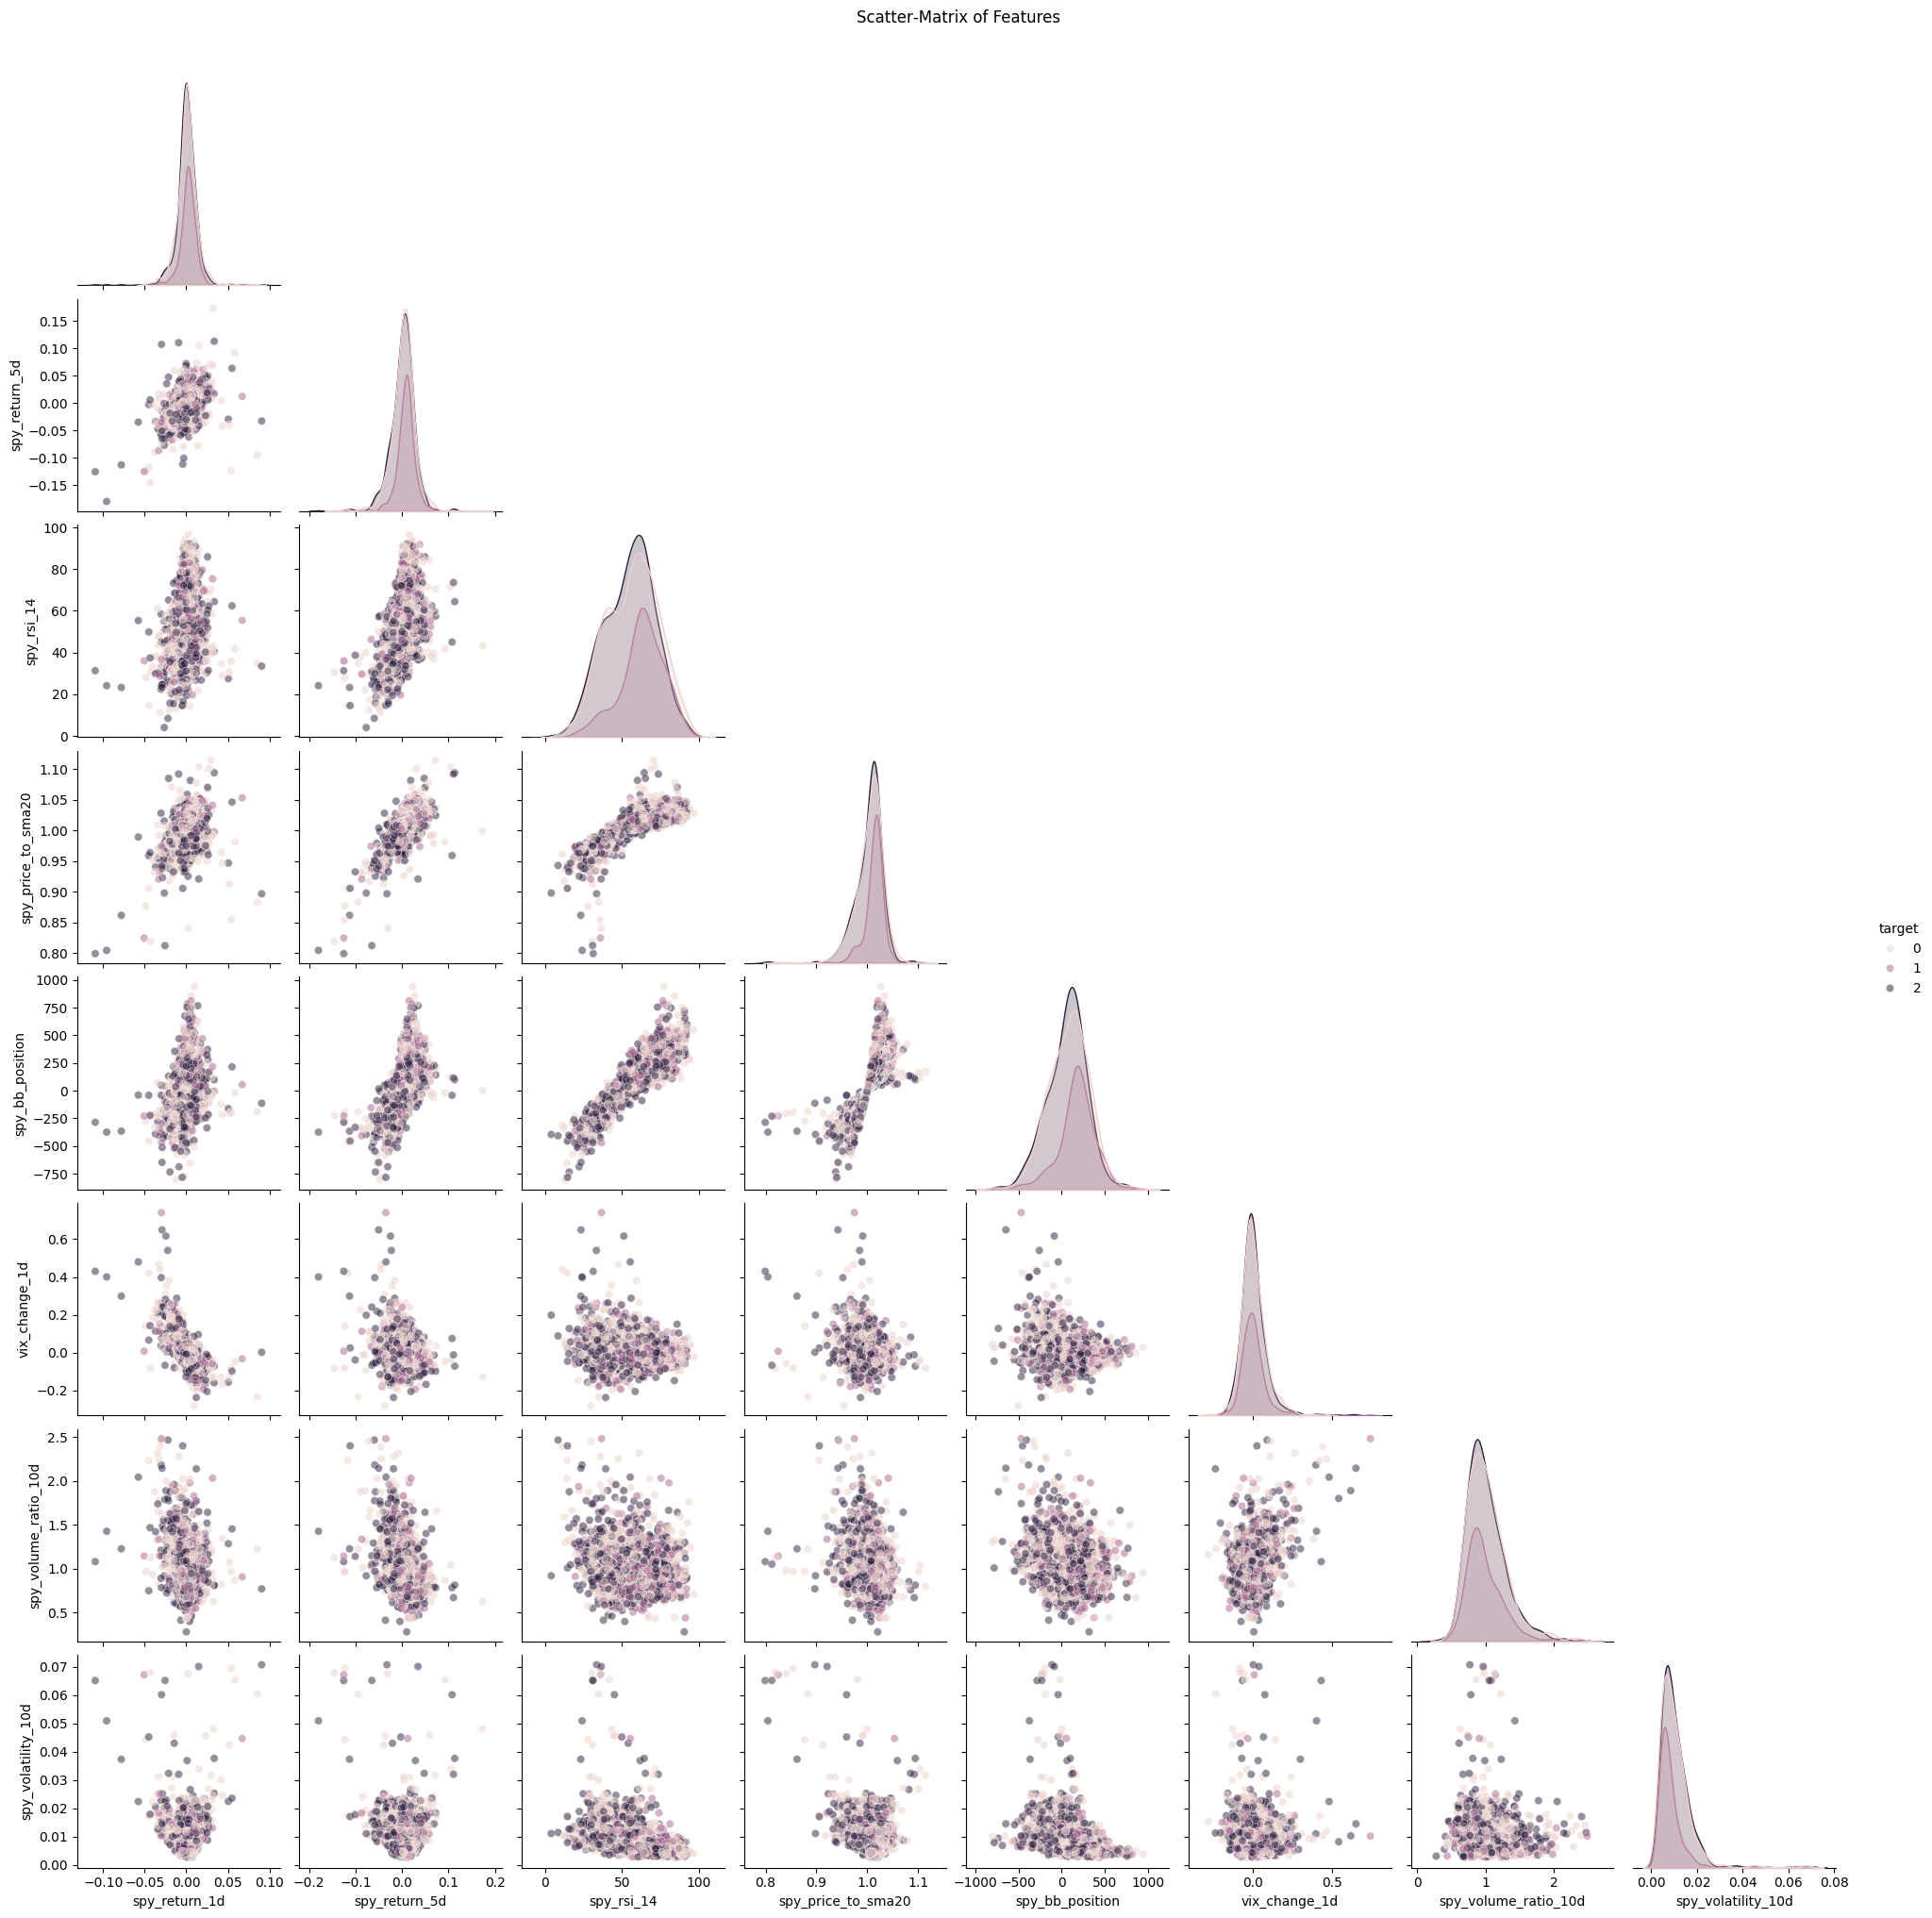

In [5]:
sns.pairplot(
    data = df,
    vars=X.columns.tolist(), 
    hue='target',
    diag_kind='kde',
    corner=True,
    plot_kws={'alpha':0.5}
)
plt.suptitle('Scatter‑Matrix of Features', y=1.02)
plt.show()


In [6]:
n_total = len(df)
n_train = int(n_total * 0.8)


train_df = df.iloc[:n_train]
test_df  = df.iloc[n_train:]


X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

X_test = X.iloc[n_train:]
y_test = y.iloc[n_train:]

X_train.shape, y_train.shape, X_train.shape, y_test.shape

((1368, 8), (1368, 1), (1368, 8), (343, 1))

In [7]:
y_train = pd.get_dummies(y_train, columns=['target'] , dtype=int)
y_train.head()


,target_0,target_1,target_2
Date,,,
2018-03-14,1,0,0
2018-03-15,0,1,0
2018-03-16,1,0,0
2018-03-19,0,1,0
2018-03-20,1,0,0


In [8]:
y_test = pd.get_dummies(y_test, columns=['target'], dtype=int)
y_test.head()

,target_0,target_1,target_2
Date,,,
2023-08-21,1,0,0
2023-08-22,0,0,1
2023-08-23,1,0,0
2023-08-24,0,0,1
2023-08-25,0,0,1


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
baseline_fnn_model = Sequential()
baseline_fnn_model.add(Input(shape=(X_train.shape[1],)))
baseline_fnn_model.add(Dense(64, activation='relu'))
baseline_fnn_model.add(Dropout(0.3))
baseline_fnn_model.add(Dense(32, activation='relu'))
baseline_fnn_model.add(Dropout(0.3))
baseline_fnn_model.add(Dense(y_train.shape[1], activation='softmax'))


baseline_fnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
baseline_fnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,755 (10.76 KB)

 Trainable params: 2,755 (10.76 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = baseline_fnn_model.fit(
    X_train_scaled, 
    y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3420 - loss: 1.1411 - val_accuracy: 0.3905 - val_loss: 1.0386
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4000 - loss: 1.0852 - val_accuracy: 0.3832 - val_loss: 1.0336
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3771 - loss: 1.0763 - val_accuracy: 0.3869 - val_loss: 1.0307
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4048 - loss: 1.0552 - val_accuracy: 0.3978 - val_loss: 1.0240
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4215 - loss: 1.0571 - val_accuracy: 0.4088 - val_loss: 1.0184
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4457 - loss: 1.0502 - val_accuracy: 0.4124 - val_loss: 1.0169
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3967 - loss: 1.0500 - val_accuracy: 0.4088 - val_loss: 1.0146
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4754 - loss: 1.0405 - val_accuracy: 0.3759 - val_loss:

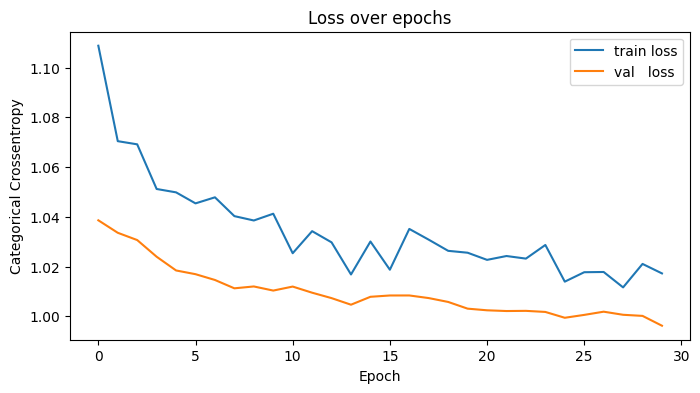

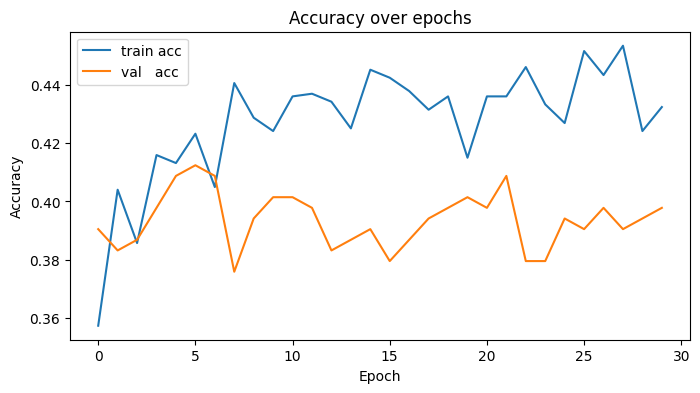

In [12]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],    label='train loss')
plt.plot(history.history['val_loss'],label='val   loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.legend()
plt.show()

# 3) Plot training & validation accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'],      label='train acc')
plt.plot(history.history['val_accuracy'],  label='val   acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
if y_test.ndim == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test


y_proba = baseline_fnn_model.predict(X_test)     
y_pred = np.argmax(y_proba, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


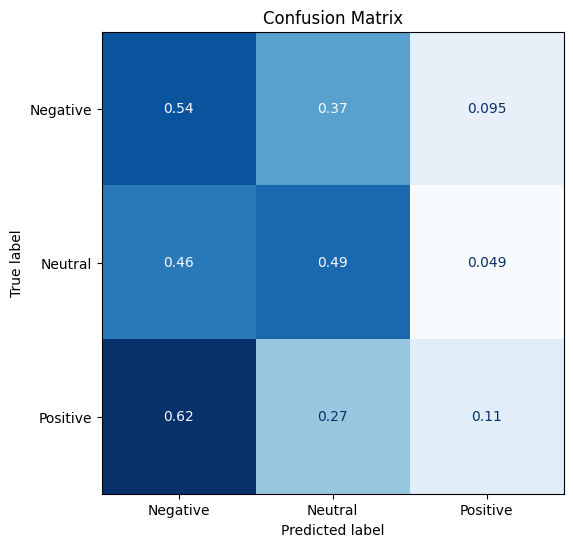

In [14]:
cm = confusion_matrix(y_true, y_pred , normalize='true')


disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Negative','Neutral','Positive']
)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix")
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


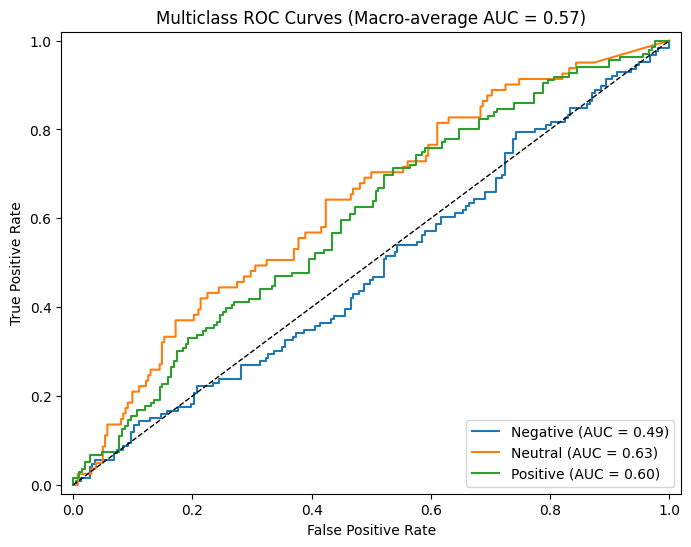

In [15]:
y_true = np.argmax(y_test, axis=1) if y_test.ndim==2 else y_test
y_proba = baseline_fnn_model.predict(X_test)


y_bin = label_binarize(y_true, classes=[0,1,2])
n_classes = y_bin.shape[1]


fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_auc_macro = roc_auc_score(
    y_bin, y_proba,
    average='macro',
    multi_class='ovr'
)


class_names = {0: "Negative", 1: "Neutral", 2: "Positive"}
colors = ['C0','C1','C2']

plt.figure(figsize=(8,6))
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i],
        color=color,
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([-0.02,1.02]); plt.ylim([-0.02,1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multiclass ROC Curves (Macro‑average AUC = {roc_auc_macro:.2f})")
plt.legend(loc="lower right")
plt.show()

## 🎯 Baseline Model Observations

---

1. **Spiky Loss & Accuracy Curves**  
   Train and test loss & accuracy curves exhibit sharp fluctuations, signalling that the model may benefit from stronger regularization (e.g. dropout, weight decay).

2. **Validation Drop‑off After Epoch 5**  
   Although training accuracy trends upward (despite the spikes), the validation accuracy declines noticeably after the fifth epoch.

3. **Confusion Matrix Insights**  
   From the test‑set confusion matrix, the model’s correct prediction rates are:  
   - **Negative**: 54%  
   - **Neutral**: 49%  
   - **Negative**: 11%  
   This clearly indicates underperformance on all classes.

4. **AUC Scores**  
   - **Overall AUC**: 0.57  
   - **Negative**: 0.49  
   - **Neutral**: 0.63  
   - **Positive**: 0.60  

   These results show the baseline feed‑forward network barely outperforms a random classifier (diagonal dashed line).

5. **ROC Curve**
    - From the ROC curve we can see that there isn't a cutoff point where we can tolerate a False Negative Rate to obtain a decent True Positive Rate 

---
